In [1]:
import face_recognition
from sklearn import svm
import os
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score

ALLOWED_EXTENSIONS = {'png', 'jpg', 'pgm'}

In [2]:
def training_svm(training_dir, model_dest_path):
    X=[]
    Y=[]
    for class_dir in os.listdir(training_dir):
        print(f"Processing Person:{class_dir}")
        if not os.path.isdir(os.path.join(training_dir, class_dir)):
            continue
        for img_path in os.listdir(os.path.join(training_dir, class_dir)):
            if os.path.splitext(img_path)[1][1:] not in ALLOWED_EXTENSIONS:
                continue

            image = face_recognition.load_image_file(os.path.join(training_dir,class_dir,img_path))
            face_bounding_boxes = face_recognition.face_locations(image)


            #If training image contains exactly one face
            if len(face_bounding_boxes) == 1:
                face_enc = face_recognition.face_encodings(image, known_face_locations=face_bounding_boxes)[0]
                # Add face encoding for current image and label
                X.append(face_enc)
                Y.append(class_dir)
                #print(f"{class_dir}Adding")
            else:
                # Case when not one face
                pass
                #print(f"{class_dir} was skipped and can't be used for training")

    # training the SVC classifier
    svm_classifier = svm.SVC(gamma='scale',probability=True)
    svm_classifier.fit(X,Y)
    if model_dest_path is not None:
        with open(model_dest_path, 'wb') as f:
            pickle.dump(svm_classifier, f)
    return svm_classifier

In [3]:
def predict_svm(img_path, svm_classifier=None, model_path=None):

    if not os.path.isfile(img_path) or os.path.splitext(img_path)[1][1:] not in ALLOWED_EXTENSIONS:
        raise Exception("Invalid image path: {}".format(img_path))

    if svm_classifier is None and model_path is None:
        raise Exception("No SVM Classifier passed")

    # Loading svm model
    if svm_classifier is None:
        with open(model_path, 'rb') as f:
            svm_classifier = pickle.load(f)

    frame = face_recognition.load_image_file(img_path)
    face_locations = face_recognition.face_locations(frame)

    # case no faces are found
    if len(face_locations) == 0:
        return [(['Unknown'],[face_locations])]

    # find encodings for faces 
    faces_encodings = face_recognition.face_encodings(frame, known_face_locations=face_locations)[0]
    # Use the SVM model to find the best matches for the test face
    name=svm_classifier.predict([faces_encodings])
    probability=svm_classifier.predict_proba([faces_encodings])
    if max(probability[0])>0.85 :
        return [(name,face_locations)]
    else :
        return [(['Unknown'],face_locations)]


In [4]:
def test(test_dir, model_path):
    y_pred = []
    y_act = []
    for class_dir in os.listdir(test_dir):
        print(f"Processing Person:{class_dir}")
        if not os.path.isdir(os.path.join(test_dir, class_dir)):
            continue

        for img_path in os.listdir(os.path.join(test_dir, class_dir)):
            img_file = os.path.join(test_dir, class_dir,img_path)
            if os.path.splitext(img_path)[1][1:] not in ALLOWED_EXTENSIONS:
                continue

            prediction = predict_svm(img_file, model_path=model_path)
            y_act.append(class_dir)
            if len(prediction) == 0:
                y_pred.append("unknown")
                continue
                
            y_pred.append(prediction[0][0][0])

    return y_pred, y_act

            

In [5]:
# Training the svm classifier and saving it too
clf = training_svm("train", "svm.clf")


Processing Person:yaleB11
Processing Person:yaleB12
Processing Person:yaleB13
Processing Person:yaleB15
Processing Person:yaleB16
Processing Person:yaleB17
Processing Person:yaleB18
Processing Person:yaleB19
Processing Person:yaleB20
Processing Person:yaleB21


In [6]:
# Making predictions on the test set
y_pred, y_act = test("test", model_path="analysis_knn.clf")

Processing Person:yaleB11
Processing Person:yaleB12
Processing Person:yaleB13
Processing Person:yaleB15
Processing Person:yaleB16
Processing Person:yaleB17
Processing Person:yaleB18
Processing Person:yaleB19
Processing Person:yaleB20
Processing Person:yaleB21


Accuracy of the model is 0.93
Visualizing the confusion matrix


<AxesSubplot:>

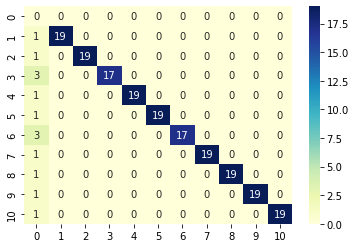

In [7]:
print("Accuracy of the model is",accuracy_score(y_act, y_pred))

print("Visualizing the confusion matrix")
conf = confusion_matrix(y_act, y_pred)
sns.heatmap(conf, annot=True, cmap="YlGnBu")